Сначала делала задание, используя SimpleCnn из ноутбука simpsons_baseline, дополненную слоями дропаута и несколькими полносвязными слоями, но на данных после аугментации сеть не училась, скор никак не изменялся. Я не смогла найти, в чем была проблема, поэтому решила использовать предобученную сеть, и сделала задание на основе кода и сети Реснет из ноутбука https://www.kaggle.com/thegreywolfs/simpsons-baseline-ipynb,  со своими дополнениями.
Опишу изменения, которые я внесла, и историю обучения сетей в хронологическом порядке:
1. Я переписала код для оверсэмплинга, потому что изначальный код не работал так, как нужно
2. Обучение сети resnet как Feature Extractor (замороженные веса), 30 эпох, батчи по 4 объекта. Скор на kaggle - 0.68331
3. Обучение сети resnet - Fine_Tuning, 25+7 эпох, батчи по 128 объектов. Скор на kaggle - 0.92136
4. Добавила паддинг и афинное преобразование в этап аугментации данных
5. Обучение сети resnet как Feature Extractor на данных с новой агументацией и батчом в 128 объектов, но обучение вышло на плато при accuracy в районе 0.5
6.  Обучение сети resnet - Fine_Tuning, за основу взяты веса сети из пункта 3. Эпох 10+13, батчи по 128 объектов. Скор на kaggle - 0.98087

In [3]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [4]:
!unzip -q /content/gdrive/MyDrive/journey_springfield.zip -d journey_springfield

In [5]:
!ls journey_springfield

characters_illustration.png  sample_submission.csv  testset  train


In [6]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [7]:
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [8]:
import pickle
import numpy as np
import random
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [9]:
SEED = 1937

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True


In [10]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

In [11]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image


    # паддинг, чтобы квадратное изображение не было растянутым, из комментария
    # https://stepik.org/lesson/345648/step/1?discussion=3192319&unit=521512
    def _prepare_sample(self, image):
        H = image.size[1]
        W = image.size[0]

        if H>W:
            image = transforms.functional.pad(image,padding=[round(abs(H-W)/2),0]) 
        else:
            image = transforms.functional.pad(image,padding=[0,round(abs(H-W)/2)])
        return image    
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        if self.mode == 'train': 
            transform = transforms.Compose([
                transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
                transforms.RandomRotation(degrees=30), # Поверните изображение на угол
                transforms.RandomHorizontalFlip(),
                transforms.RandomAffine(degrees=(-15, 15)), # Случайное аффинное преобразование изображения с сохранением инвариантности центра
                transforms.ColorJitter(hue=.1, saturation=.1), # Произвольно изменяйте яркость, контраст, насыщенность и оттенок изображения
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ])
        else:
            transform = transforms.Compose([
                transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

In [12]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [13]:
TRAIN_DIR = Path('journey_springfield/train/simpsons_dataset')
TEST_DIR = Path('journey_springfield/testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
train_val_labels = [path.parent.name for path in train_val_files]
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [14]:
# Создадим словарь в котором ключами будут персонажи Симпсонов, а значениями списки с путями к картинкам
def create_dct_path_labels(train_files, train_labels):
    dct_simpsons = {}
    for label_i in np.unique(train_labels).tolist():
        dct_simpsons[label_i] = []

    for path_i, label_i in zip(train_files, train_labels):
        dct_simpsons[label_i].append(path_i)

    return dct_simpsons

# dct_path_train = create_dct_path_labels(train_files, train_dataset.labels)
dct_path_train = create_dct_path_labels(train_val_files, train_val_labels)

# Дополним картинки классов у которых менее 100 картинок, до 100 картинок в классе
for person in dct_path_train:
    if len(dct_path_train[person]) < 100:
        dct_path_train[person] = dct_path_train[person] * (100 // len(dct_path_train[person]))
        dct_path_train[person].extend(dct_path_train[person][:100 - len(dct_path_train[person])]) # extend - Дополняет список элементами из указанного объекта
# Проверим что получилось 
for person in dct_path_train:
    print(f"{person}\t{len(dct_path_train[person])}")

abraham_grampa_simpson	913
agnes_skinner	100
apu_nahasapeemapetilon	623
barney_gumble	106
bart_simpson	1342
carl_carlson	100
charles_montgomery_burns	1193
chief_wiggum	986
cletus_spuckler	100
comic_book_guy	469
disco_stu	100
edna_krabappel	457
fat_tony	100
gil	100
groundskeeper_willie	121
homer_simpson	2246
kent_brockman	498
krusty_the_clown	1206
lenny_leonard	310
lionel_hutz	100
lisa_simpson	1354
maggie_simpson	128
marge_simpson	1291
martin_prince	100
mayor_quimby	246
milhouse_van_houten	1079
miss_hoover	100
moe_szyslak	1452
ned_flanders	1454
nelson_muntz	358
otto_mann	100
patty_bouvier	100
principal_skinner	1194
professor_john_frink	100
rainier_wolfcastle	100
ralph_wiggum	100
selma_bouvier	103
sideshow_bob	877
sideshow_mel	100
snake_jailbird	100
troy_mcclure	100
waylon_smithers	181


In [15]:
# Создадим новый файл с дополненными минорными классами
new_train_val_files = []

for person in dct_path_train:
    new_train_val_files.extend(dct_path_train[person])

new_train_val_labels = [path.parent.name for path in new_train_val_files]    

In [16]:
from sklearn.model_selection import train_test_split

train_files, val_files = train_test_split(new_train_val_files, test_size=0.25, \
                                          stratify=new_train_val_labels)

In [17]:
val_dataset = SimpsonsDataset(val_files, mode='val')
new_train_dataset = SimpsonsDataset(train_files, mode='train')

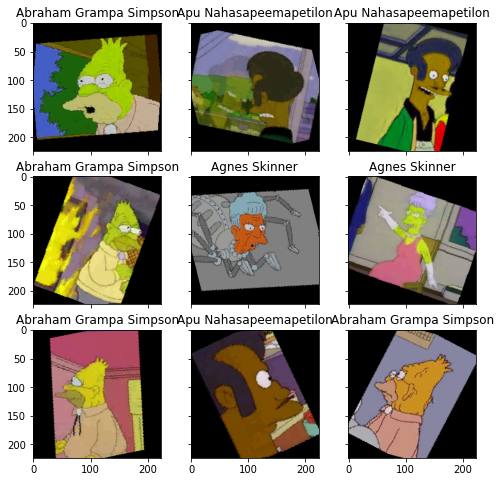

In [47]:
# примеры картинок на трейне

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = new_train_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

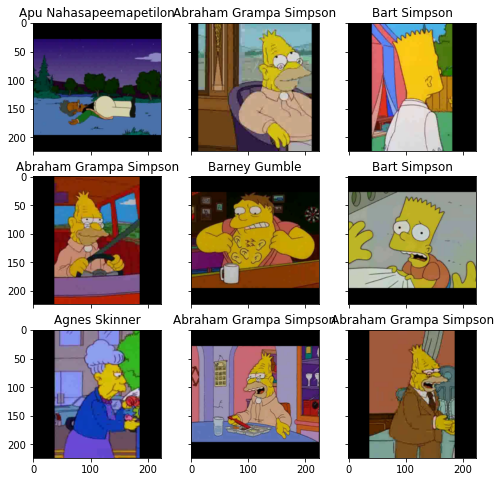

In [48]:
# примеры картинок на валидации

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

In [18]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [19]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size # .double() == torch.float64 
    return val_loss, val_acc

In [20]:
def train(train_dataset, val_dataset, model, epochs, batch_size, shuffle=True, sampler=None):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, sampler=sampler, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.AdamW(model.parameters())
        scheduler = torch.optim.lr_scheduler.StepLR(opt, 3, 0.5)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            scheduler.step()
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [21]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [22]:
n_classes = len(np.unique(train_val_labels))

In [26]:
# torch.cuda.empty_cache() 

# Resnet как Feature Extractor

In [23]:
from torchvision import models

In [46]:
# 30 эпох resnet как Feature Extractor (замороженные веса)

model_resnet = models.resnet18(pretrained=True).to(DEVICE)
child_counter = 0
for child in model_resnet.children():
    print(" child", child_counter, "is:")
    print(child)
    child_counter += 1

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth



 child 0 is:
Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
 child 1 is:
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 child 2 is:
ReLU(inplace=True)
 child 3 is:
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
 child 4 is:
Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(6

In [ ]:
# 30 эпох resnet как Feature Extractor (замороженные веса)

model_resnet.fc = nn.Sequential(nn.Linear(512,n_classes))

# Выключаем подсчет градиентов для слоев, которые не будем обучать
for i, child in enumerate(model_resnet.children()):
    if i not in [9]:
        for param in child.parameters():
            param.requires_grad = False

model_resnet = model_resnet.cuda()

In [ ]:
# 30 эпох resnet как Feature Extractor (замороженные веса)

history = train(new_train_dataset, val_dataset, model=model_resnet, epochs=30, batch_size=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
epoch:   0%|          | 0/30 [00:00<?, ?it/s]

loss 2.5550160451738564


epoch:   3%|▎         | 1/30 [03:38<1:45:44, 218.78s/it]


Epoch 001 train_loss: 2.5550     val_loss 1.9138 train_acc 0.3257 val_acc 0.4874
loss 1.6567795819764888


epoch:   7%|▋         | 2/30 [07:16<1:41:57, 218.48s/it]


Epoch 002 train_loss: 1.6568     val_loss 1.5538 train_acc 0.5512 val_acc 0.5833
loss 1.4924587108237948


epoch:  10%|█         | 3/30 [10:51<1:37:46, 217.27s/it]


Epoch 003 train_loss: 1.4925     val_loss 1.3978 train_acc 0.5886 val_acc 0.6248
loss 1.3081277285194455


epoch:  13%|█▎        | 4/30 [14:21<1:33:14, 215.17s/it]


Epoch 004 train_loss: 1.3081     val_loss 1.2806 train_acc 0.6284 val_acc 0.6482
loss 1.2661982273791317


epoch:  17%|█▋        | 5/30 [17:53<1:29:14, 214.18s/it]


Epoch 005 train_loss: 1.2662     val_loss 1.3462 train_acc 0.6414 val_acc 0.6400
loss 1.2553318544922716


epoch:  20%|██        | 6/30 [21:24<1:25:16, 213.19s/it]


Epoch 006 train_loss: 1.2553     val_loss 1.3599 train_acc 0.6467 val_acc 0.6307
loss 1.1666884737709402


epoch:  23%|██▎       | 7/30 [24:57<1:21:47, 213.37s/it]


Epoch 007 train_loss: 1.1667     val_loss 1.2394 train_acc 0.6651 val_acc 0.6648
loss 1.1743242957943865


epoch:  27%|██▋       | 8/30 [28:33<1:18:28, 214.02s/it]


Epoch 008 train_loss: 1.1743     val_loss 1.2763 train_acc 0.6653 val_acc 0.6469
loss 1.1499375909827865


epoch:  30%|███       | 9/30 [32:06<1:14:46, 213.66s/it]


Epoch 009 train_loss: 1.1499     val_loss 1.2866 train_acc 0.6708 val_acc 0.6442
loss 1.1174583265631075


epoch:  33%|███▎      | 10/30 [35:39<1:11:13, 213.65s/it]


Epoch 010 train_loss: 1.1175     val_loss 1.2028 train_acc 0.6810 val_acc 0.6736
loss 1.1128455365490266


epoch:  37%|███▋      | 11/30 [39:14<1:07:43, 213.86s/it]


Epoch 011 train_loss: 1.1128     val_loss 1.2317 train_acc 0.6852 val_acc 0.6628
loss 1.1060648266408744


epoch:  40%|████      | 12/30 [42:52<1:04:32, 215.13s/it]


Epoch 012 train_loss: 1.1061     val_loss 1.2232 train_acc 0.6841 val_acc 0.6656
loss 1.0905622774808283


epoch:  43%|████▎     | 13/30 [46:23<1:00:35, 213.87s/it]


Epoch 013 train_loss: 1.0906     val_loss 1.1997 train_acc 0.6877 val_acc 0.6756
loss 1.1024718282040193


epoch:  47%|████▋     | 14/30 [49:55<56:55, 213.47s/it]


Epoch 014 train_loss: 1.1025     val_loss 1.1922 train_acc 0.6872 val_acc 0.6784
loss 1.0965238098757517


epoch:  50%|█████     | 15/30 [53:39<54:07, 216.48s/it]


Epoch 015 train_loss: 1.0965     val_loss 1.1925 train_acc 0.6925 val_acc 0.6776
loss 1.0872793359198005


epoch:  53%|█████▎    | 16/30 [57:22<50:59, 218.52s/it]


Epoch 016 train_loss: 1.0873     val_loss 1.1888 train_acc 0.6918 val_acc 0.6778
loss 1.0772502358949496


epoch:  57%|█████▋    | 17/30 [1:01:04<47:32, 219.46s/it]


Epoch 017 train_loss: 1.0773     val_loss 1.1884 train_acc 0.6942 val_acc 0.6769
loss 1.0733952989038664


epoch:  60%|██████    | 18/30 [1:04:47<44:05, 220.49s/it]


Epoch 018 train_loss: 1.0734     val_loss 1.1867 train_acc 0.6944 val_acc 0.6789
loss 1.0780114649366923


epoch:  63%|██████▎   | 19/30 [1:08:17<39:51, 217.39s/it]


Epoch 019 train_loss: 1.0780     val_loss 1.1856 train_acc 0.6887 val_acc 0.6793
loss 1.0734602207781483


epoch:  67%|██████▋   | 20/30 [1:11:46<35:50, 215.01s/it]


Epoch 020 train_loss: 1.0735     val_loss 1.1779 train_acc 0.6965 val_acc 0.6802
loss 1.0720624998352566


epoch:  70%|███████   | 21/30 [1:15:15<31:57, 213.01s/it]


Epoch 021 train_loss: 1.0721     val_loss 1.1803 train_acc 0.6968 val_acc 0.6822
loss 1.074398839768298


epoch:  73%|███████▎  | 22/30 [1:18:41<28:08, 211.03s/it]


Epoch 022 train_loss: 1.0744     val_loss 1.1784 train_acc 0.6906 val_acc 0.6811
loss 1.0779260554266092


epoch:  77%|███████▋  | 23/30 [1:22:09<24:31, 210.15s/it]


Epoch 023 train_loss: 1.0779     val_loss 1.1787 train_acc 0.6961 val_acc 0.6809
loss 1.0860446429900776


epoch:  80%|████████  | 24/30 [1:25:37<20:57, 209.64s/it]


Epoch 024 train_loss: 1.0860     val_loss 1.1791 train_acc 0.6928 val_acc 0.6809
loss 1.076707067961305


epoch:  83%|████████▎ | 25/30 [1:29:06<17:26, 209.30s/it]


Epoch 025 train_loss: 1.0767     val_loss 1.1770 train_acc 0.6964 val_acc 0.6827
loss 1.0561986379540986


epoch:  87%|████████▋ | 26/30 [1:32:40<14:02, 210.63s/it]


Epoch 026 train_loss: 1.0562     val_loss 1.1778 train_acc 0.6990 val_acc 0.6811
loss 1.0752204959577234


epoch:  90%|█████████ | 27/30 [1:36:18<10:39, 213.06s/it]


Epoch 027 train_loss: 1.0752     val_loss 1.1781 train_acc 0.6964 val_acc 0.6807
loss 1.0764044907569268


epoch:  93%|█████████▎| 28/30 [1:39:58<07:09, 214.88s/it]


Epoch 028 train_loss: 1.0764     val_loss 1.1771 train_acc 0.6948 val_acc 0.6822
loss 1.080423762766628


epoch:  97%|█████████▋| 29/30 [1:43:29<03:33, 213.71s/it]


Epoch 029 train_loss: 1.0804     val_loss 1.1778 train_acc 0.6914 val_acc 0.6820
loss 1.0687831655058453


epoch: 100%|██████████| 30/30 [1:47:07<00:00, 214.24s/it]


Epoch 030 train_loss: 1.0688     val_loss 1.1774 train_acc 0.6997 val_acc 0.6818


In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

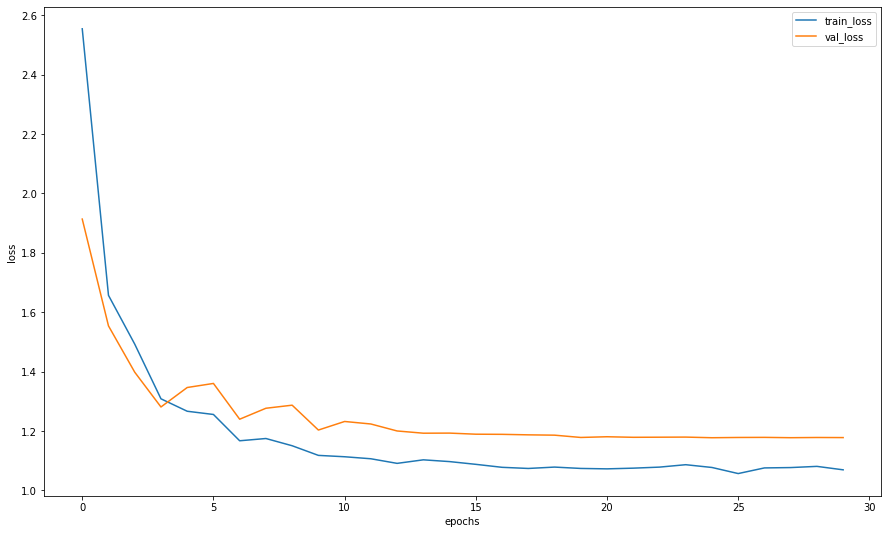

In [ ]:
# 30 эпох resnet как Feature Extractor

plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

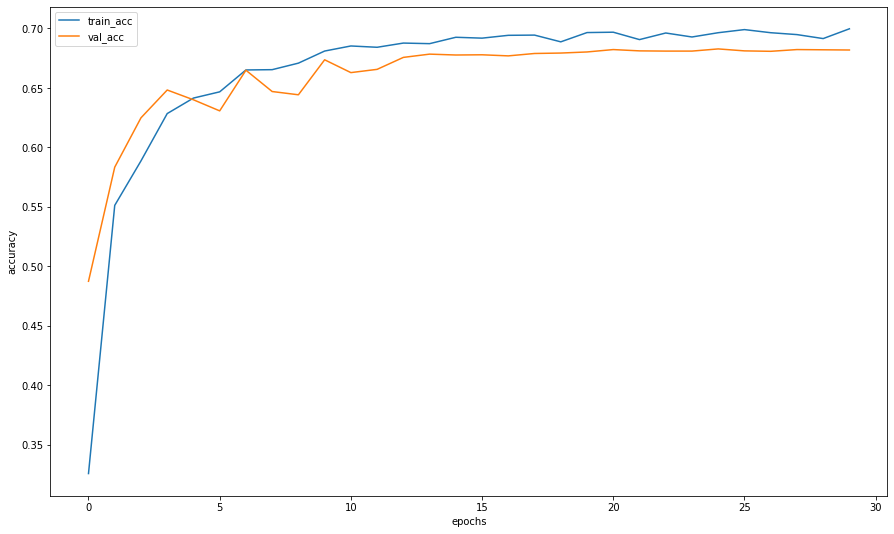

In [ ]:
# 30 эпох resnet как Feature Extractor

plt.figure(figsize=(15, 9))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

Это было первое обучение, которое у меня получилось, поэтому на пробу взяла батч в 4 объекта. После 15 эпохи обучение застопорилось, видимо, сеть нашла локальный минимум? Скор на kaggle - 0.68331

#  Resnet - Fine_Tuning

In [ ]:
 # 25 + 7 эпох resnet Fine_Tuning

model_resnet_Fine_Tuning = models.resnet18(pretrained=True).to(DEVICE)

model_resnet_Fine_Tuning.fc = nn.Sequential(nn.Linear(512,42))

# Включаем все слои!!!
for child in model_resnet_Fine_Tuning.children():
    for param in child.parameters():
        param.requires_grad = True

model_resnet_Fine_Tuning = model_resnet_Fine_Tuning.cuda()

In [ ]:
 # 25 + 7 эпох resnet Fine_Tuning
 # ВЫВЕДЕНА ИСТОРИЯ ТОЛЬКО ДЛЯ ОБУЧЕНИЯ НА 7 ЭПОХАХ

history = train(new_train_dataset, val_dataset, model=model_resnet_Fine_Tuning, epochs=7, batch_size=128)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
epoch:   0%|          | 0/7 [00:00<?, ?it/s]

loss 2.569640024515176


epoch:  14%|█▍        | 1/7 [03:44<22:26, 224.39s/it]


Epoch 001 train_loss: 2.5696     val_loss 1.5614 train_acc 0.3594 val_acc 0.5532
loss 1.1079368251291601


epoch:  29%|██▊       | 2/7 [07:28<18:41, 224.34s/it]


Epoch 002 train_loss: 1.1079     val_loss 0.8593 train_acc 0.6855 val_acc 0.7564
loss 0.767567694045551


epoch:  43%|████▎     | 3/7 [11:13<14:57, 224.44s/it]


Epoch 003 train_loss: 0.7676     val_loss 0.6666 train_acc 0.7834 val_acc 0.8165
loss 0.49967332382300916


epoch:  57%|█████▋    | 4/7 [14:58<11:13, 224.63s/it]


Epoch 004 train_loss: 0.4997     val_loss 0.5134 train_acc 0.8563 val_acc 0.8633
loss 0.43383237987330076


epoch:  71%|███████▏  | 5/7 [18:43<07:29, 224.74s/it]


Epoch 005 train_loss: 0.4338     val_loss 0.5083 train_acc 0.8747 val_acc 0.8704
loss 0.37363314744433435


epoch:  86%|████████▌ | 6/7 [22:28<03:44, 224.92s/it]


Epoch 006 train_loss: 0.3736     val_loss 0.5396 train_acc 0.8914 val_acc 0.8648
loss 0.26245079395649745


epoch: 100%|██████████| 7/7 [26:13<00:00, 224.80s/it]


Epoch 007 train_loss: 0.2625     val_loss 0.4385 train_acc 0.9234 val_acc 0.8931


In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

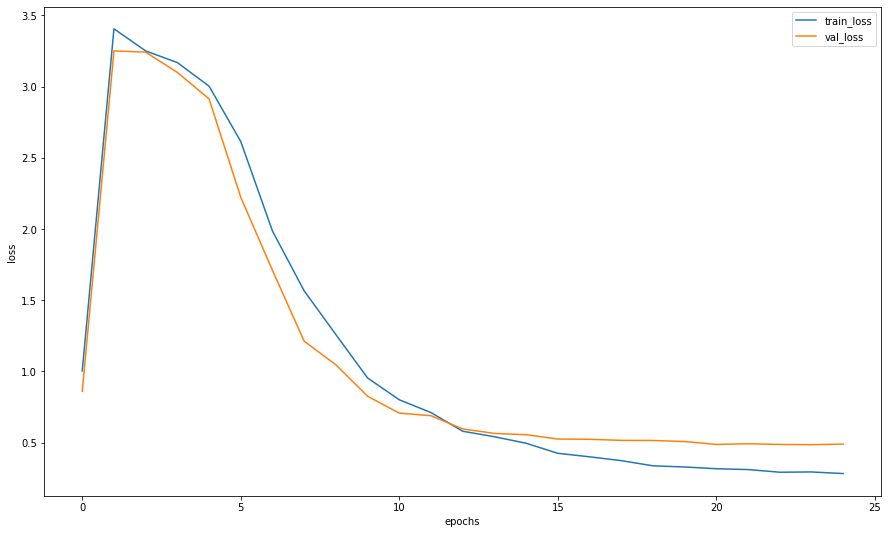

In [ ]:
 # 25 эпох resnet Fine_Tuning

plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

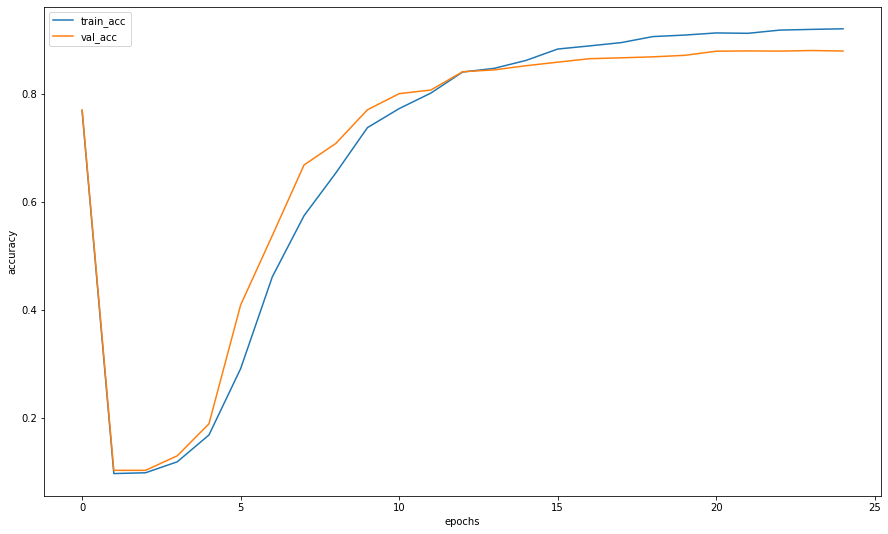

In [ ]:
 # 25 эпох resnet Fine_Tuning

plt.figure(figsize=(15, 9))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

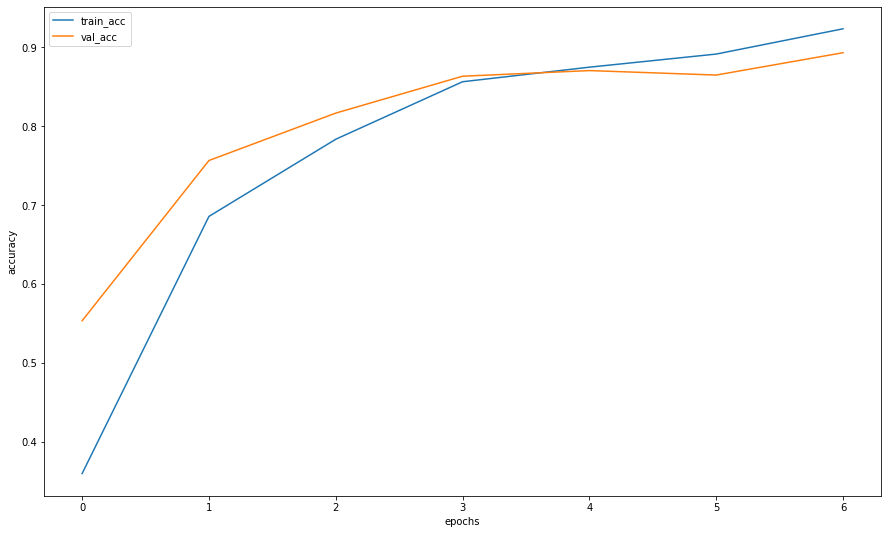

In [ ]:
 # еще 7 эпох resnet Fine_Tuning

plt.figure(figsize=(15, 9))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

In [ ]:
# сохраним веса нашей нейросети
model_7_epoch_Fine_Tuning = copy.deepcopy(model_resnet_Fine_Tuning.state_dict())
torch.save(model_7_epoch_Fine_Tuning, "/content/gdrive/MyDrive/model_7_128_epoch_Fine_Tuning.pth")

Стратегия Fine_Tuning сработала явно лучше, чем Feature Extractor. Скор на kaggle - 0.92136

# Resnet как Feature Extractor - 2

In [55]:
model_resnet_17_05 = models.resnet18(pretrained=True).to(DEVICE)
child_counter = 0
for child in model_resnet_17_05.children():
    print(" child", child_counter, "is:")
    print(child)
    child_counter += 1

 child 0 is:
Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
 child 1 is:
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 child 2 is:
ReLU(inplace=True)
 child 3 is:
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
 child 4 is:
Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64

In [56]:
model_resnet_17_05.fc = nn.Sequential(nn.Linear(512,n_classes))

# Выключаем подсчет градиентов для слоев, которые не будем обучать
for i, child in enumerate(model_resnet_17_05.children()):
    if i not in [9]:
        for param in child.parameters():
            param.requires_grad = False

model_resnet_17_05 = model_resnet_17_05.cuda()

In [57]:
# 15 эпох resnet как Feature Extractor (замороженные веса) 17.05
# ПРЕРВАЛА ОБУЧЕНИЕ, Т.К. ВИДЕН ВЫХОД НА ПЛАТО val_acc

history = train(new_train_dataset, val_dataset, model=model_resnet_17_05, epochs=15, batch_size=128)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
epoch:   0%|          | 0/15 [00:00<?, ?it/s]

loss 2.8481612242542678


epoch:   7%|▋         | 1/15 [02:47<39:08, 167.72s/it]


Epoch 001 train_loss: 2.8482     val_loss 2.5024 train_acc 0.2540 val_acc 0.3483
loss 2.2026346781614747


epoch:  13%|█▎        | 2/15 [05:36<36:22, 167.90s/it]


Epoch 002 train_loss: 2.2026     val_loss 2.1370 train_acc 0.4447 val_acc 0.4582
loss 1.9346083470971127


epoch:  20%|██        | 3/15 [08:23<33:32, 167.75s/it]


Epoch 003 train_loss: 1.9346     val_loss 1.9376 train_acc 0.5012 val_acc 0.4947
loss 1.7950894330283544


epoch:  27%|██▋       | 4/15 [11:09<30:39, 167.26s/it]


Epoch 004 train_loss: 1.7951     val_loss 1.8841 train_acc 0.5280 val_acc 0.4989
loss 1.7342481545402697


epoch:  33%|███▎      | 5/15 [13:53<27:43, 166.38s/it]


Epoch 005 train_loss: 1.7342     val_loss 1.8264 train_acc 0.5353 val_acc 0.5161
loss 1.6831343189884969


epoch:  40%|████      | 6/15 [16:38<24:53, 166.00s/it]


Epoch 006 train_loss: 1.6831     val_loss 1.7737 train_acc 0.5524 val_acc 0.5342
loss 1.6367119812435251


epoch:  47%|████▋     | 7/15 [19:24<22:05, 165.73s/it]


Epoch 007 train_loss: 1.6367     val_loss 1.7634 train_acc 0.5667 val_acc 0.5283
loss 1.6072443105663936


epoch:  53%|█████▎    | 8/15 [22:08<19:18, 165.45s/it]


Epoch 008 train_loss: 1.6072     val_loss 1.7164 train_acc 0.5686 val_acc 0.5473


epoch:  53%|█████▎    | 8/15 [22:34<19:44, 169.27s/it]


KeyboardInterrupt: ignored

# Resnet - Fine_Tuning - 2

Доучим на данных с новой аугментацией сеть, которая показала наилучший результат - model_7_128_epoch_Fine_Tuning

In [28]:
model_resnet_16_17_05 = models.resnet18()

# загружаем сохраненное состояние весов нейросети
model_resnet_16_17_05.load_state_dict(torch.load('/content/gdrive/MyDrive/model_7_128_epoch_Fine_Tuning.pth'))
model_resnet_16_17_05 = model_resnet_16_17_05.cuda()

In [29]:
history = train(new_train_dataset, val_dataset, model=model_resnet_16_17_05, epochs=10, batch_size=128)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 0.9168473436234748


epoch:  10%|█         | 1/10 [02:53<25:59, 173.27s/it]


Epoch 001 train_loss: 0.9168     val_loss 0.5948 train_acc 0.7533 val_acc 0.8405
loss 2.646724750681182


epoch:  20%|██        | 2/10 [05:49<23:13, 174.22s/it]


Epoch 002 train_loss: 2.6467     val_loss 1.1080 train_acc 0.3129 val_acc 0.6988
loss 0.8793854458390886


epoch:  30%|███       | 3/10 [08:46<20:25, 175.12s/it]


Epoch 003 train_loss: 0.8794     val_loss 0.7222 train_acc 0.7530 val_acc 0.7962
loss 0.4677444773115402


epoch:  40%|████      | 4/10 [11:43<17:33, 175.53s/it]


Epoch 004 train_loss: 0.4677     val_loss 0.4486 train_acc 0.8658 val_acc 0.8818
loss 0.37965190600339427


epoch:  50%|█████     | 5/10 [14:39<14:38, 175.77s/it]


Epoch 005 train_loss: 0.3797     val_loss 0.4372 train_acc 0.8916 val_acc 0.8832
loss 0.337693234966762


epoch:  60%|██████    | 6/10 [17:36<11:44, 176.02s/it]


Epoch 006 train_loss: 0.3377     val_loss 0.4112 train_acc 0.9027 val_acc 0.8980
loss 0.22861087105775657


epoch:  70%|███████   | 7/10 [20:34<08:49, 176.52s/it]


Epoch 007 train_loss: 0.2286     val_loss 0.3593 train_acc 0.9336 val_acc 0.9117
loss 0.19780625232900748


epoch:  80%|████████  | 8/10 [23:28<05:51, 175.96s/it]


Epoch 008 train_loss: 0.1978     val_loss 0.3379 train_acc 0.9426 val_acc 0.9170
loss 0.1862887017880494


epoch:  90%|█████████ | 9/10 [26:22<02:55, 175.41s/it]


Epoch 009 train_loss: 0.1863     val_loss 0.3529 train_acc 0.9451 val_acc 0.9203
loss 0.130410762034082


epoch: 100%|██████████| 10/10 [29:19<00:00, 175.98s/it]


Epoch 010 train_loss: 0.1304     val_loss 0.3316 train_acc 0.9626 val_acc 0.9238


In [31]:
# сохраним веса нашей нейросети
import copy

model_resnet_16_17_05_copy = copy.deepcopy(model_resnet_16_17_05.state_dict())
torch.save(model_resnet_16_17_05_copy, "/content/gdrive/MyDrive/model_resnet_16_17_05.pth")

In [37]:
# Доучим еще!

model_resnet_16_17_05_part2 = models.resnet18()

# загружаем сохраненное состояние весов нейросети
model_resnet_16_17_05_part2.load_state_dict(torch.load('/content/gdrive/MyDrive/model_resnet_16_17_05.pth'))
model_resnet_16_17_05_part2 = model_resnet_16_17_05_part2.cuda()

history = train(new_train_dataset, val_dataset, model=model_resnet_16_17_05_part2, epochs=13, batch_size=128)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
epoch:   0%|          | 0/13 [00:00<?, ?it/s]

loss 0.44116927123527283


epoch:   8%|▊         | 1/13 [02:55<35:08, 175.71s/it]


Epoch 001 train_loss: 0.4412     val_loss 0.4526 train_acc 0.8716 val_acc 0.8796
loss 0.4980019778439885


epoch:  15%|█▌        | 2/13 [05:51<32:13, 175.78s/it]


Epoch 002 train_loss: 0.4980     val_loss 0.5006 train_acc 0.8560 val_acc 0.8690
loss 0.312391254686652


epoch:  23%|██▎       | 3/13 [08:48<29:21, 176.20s/it]


Epoch 003 train_loss: 0.3124     val_loss 0.4221 train_acc 0.9112 val_acc 0.8904
loss 0.16929945266949414


epoch:  31%|███       | 4/13 [11:45<26:26, 176.31s/it]


Epoch 004 train_loss: 0.1693     val_loss 0.2789 train_acc 0.9511 val_acc 0.9324
loss 0.1419028159802847


epoch:  38%|███▊      | 5/13 [14:43<23:35, 176.90s/it]


Epoch 005 train_loss: 0.1419     val_loss 0.2922 train_acc 0.9587 val_acc 0.9324
loss 0.12208032518843126


epoch:  46%|████▌     | 6/13 [17:44<20:45, 177.96s/it]


Epoch 006 train_loss: 0.1221     val_loss 0.2899 train_acc 0.9635 val_acc 0.9364
loss 0.07498336497409439


epoch:  54%|█████▍    | 7/13 [20:46<17:55, 179.23s/it]


Epoch 007 train_loss: 0.0750     val_loss 0.2580 train_acc 0.9786 val_acc 0.9433
loss 0.06642233845966457


epoch:  62%|██████▏   | 8/13 [23:43<14:52, 178.48s/it]


Epoch 008 train_loss: 0.0664     val_loss 0.2726 train_acc 0.9813 val_acc 0.9412
loss 0.05197681762116949


epoch:  69%|██████▉   | 9/13 [26:35<11:46, 176.67s/it]


Epoch 009 train_loss: 0.0520     val_loss 0.2908 train_acc 0.9845 val_acc 0.9450
loss 0.03912137517290819


epoch:  77%|███████▋  | 10/13 [29:28<08:46, 175.62s/it]


Epoch 010 train_loss: 0.0391     val_loss 0.2682 train_acc 0.9889 val_acc 0.9470
loss 0.0333882310814949


epoch:  85%|████████▍ | 11/13 [32:21<05:49, 174.92s/it]


Epoch 011 train_loss: 0.0334     val_loss 0.2789 train_acc 0.9904 val_acc 0.9457
loss 0.032229122669985524


epoch:  92%|█████████▏| 12/13 [35:15<02:54, 174.59s/it]


Epoch 012 train_loss: 0.0322     val_loss 0.2729 train_acc 0.9904 val_acc 0.9494
loss 0.02648822221220756


epoch: 100%|██████████| 13/13 [38:08<00:00, 176.05s/it]


Epoch 013 train_loss: 0.0265     val_loss 0.2808 train_acc 0.9928 val_acc 0.9455


Самый лучший результат на данный момент, Скор на kaggle - 0.98087

In [38]:
# сохраним веса нашей нейросети

model_resnet_16_17_05_part2_copy = copy.deepcopy(model_resnet_16_17_05_part2.state_dict())
torch.save(model_resnet_16_17_05_part2_copy, "/content/gdrive/MyDrive/model_resnet_16_17_05_part2.pth")

Хорошо бы понять, как сделать сабмит. У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [48]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [50]:
# Предсказание для одной картинки

random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model_resnet_16_17_05_part2, ex_img.unsqueeze(0))

In [39]:
# Предсказание для 20 картинок

idxs = list(map(int, np.random.uniform(0, 1000, 20))) # 20  чисел от 0 до 1000
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model_resnet_16_17_05_part2, imgs) # вероятности классов

y_pred = np.argmax(probs_ims,-1) # предсказанные классы

actual_labels = [val_dataset[id][1] for id in idxs] # реальные классы

In [53]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

# preds_class = [label_encoder.classes_[i] for i in y_pred]

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

In [40]:
from sklearn.metrics import f1_score

f1_score(actual_labels, y_pred, average='micro')

# 0.85 - 30 эпох resnet как Feature Extractor
# 0.9 - 25 эпох resnet Fine_Tuning
# 0.8000000000000002 - еше 7 эпох resnet Fine_Tuning
# 0.9 - еше 10 эпох model_resnet_16_17_05 на базе resnet Fine_Tuning
# 1.0 - еще 13 эпох model_resnet_16_17_05 на базе resnet Fine_Tuning

1.0

Сделаем классную визуализацию, чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.


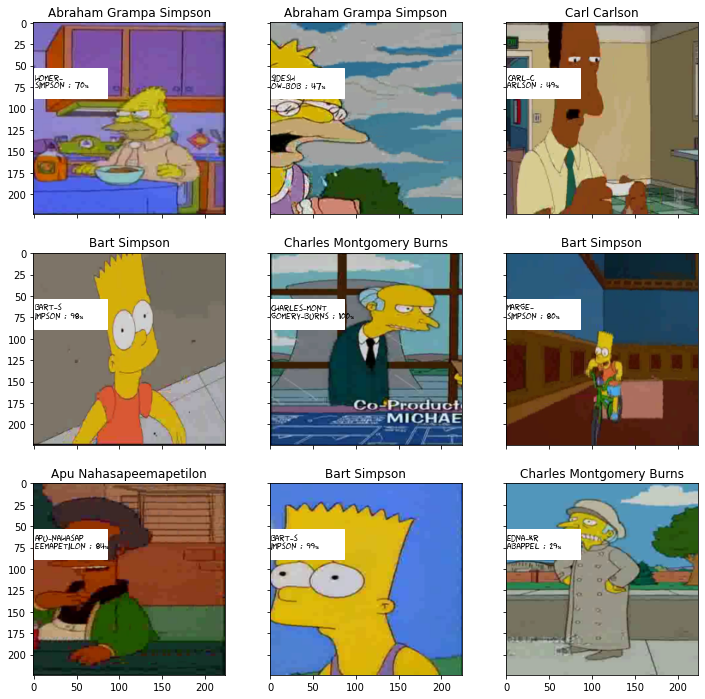

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model_resnet, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Попробуйте найти те классы, которые сеть не смогла расспознать. Изучите данную проблему, это понадобится в дальнейшем.

# **Submit на Kaggle**

In [43]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model_resnet_16_17_05_part2, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [44]:
import pandas as pd
mysubmit = pd.DataFrame(columns=['Id'])
test_filenames = [path.name for path in test_dataset.files]
mysubmit['Id'] = test_filenames
mysubmit[f'Expected'] = preds
mysubmit

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon
...,...,...
986,img987.jpg,nelson_muntz
987,img988.jpg,ned_flanders
988,img989.jpg,charles_montgomery_burns
989,img99.jpg,chief_wiggum


In [45]:
mysubmit.to_csv('/content/gdrive/MyDrive/model_resnet_16_17_05_part2.csv', index=False)